# ***Probing electron beam-induced nonlinear dynamics of graphene using the neural differential equation VAE ${\P}$***

---

Author: Paul Bao \
Data: 24 Jan, 2025

In [1]:
from typing import Dict, Tuple, Union

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn import cluster, mixture, decomposition

import cv2

In [2]:
STEM_real = np.load('./data/3DStack13-1-exp.npy')
decoded_imgs = np.load('./data/3DStack13-1-dec.npy')
lattice_coord = np.load('./data/3DStack13-1-coord.npy', allow_pickle=True)[()]

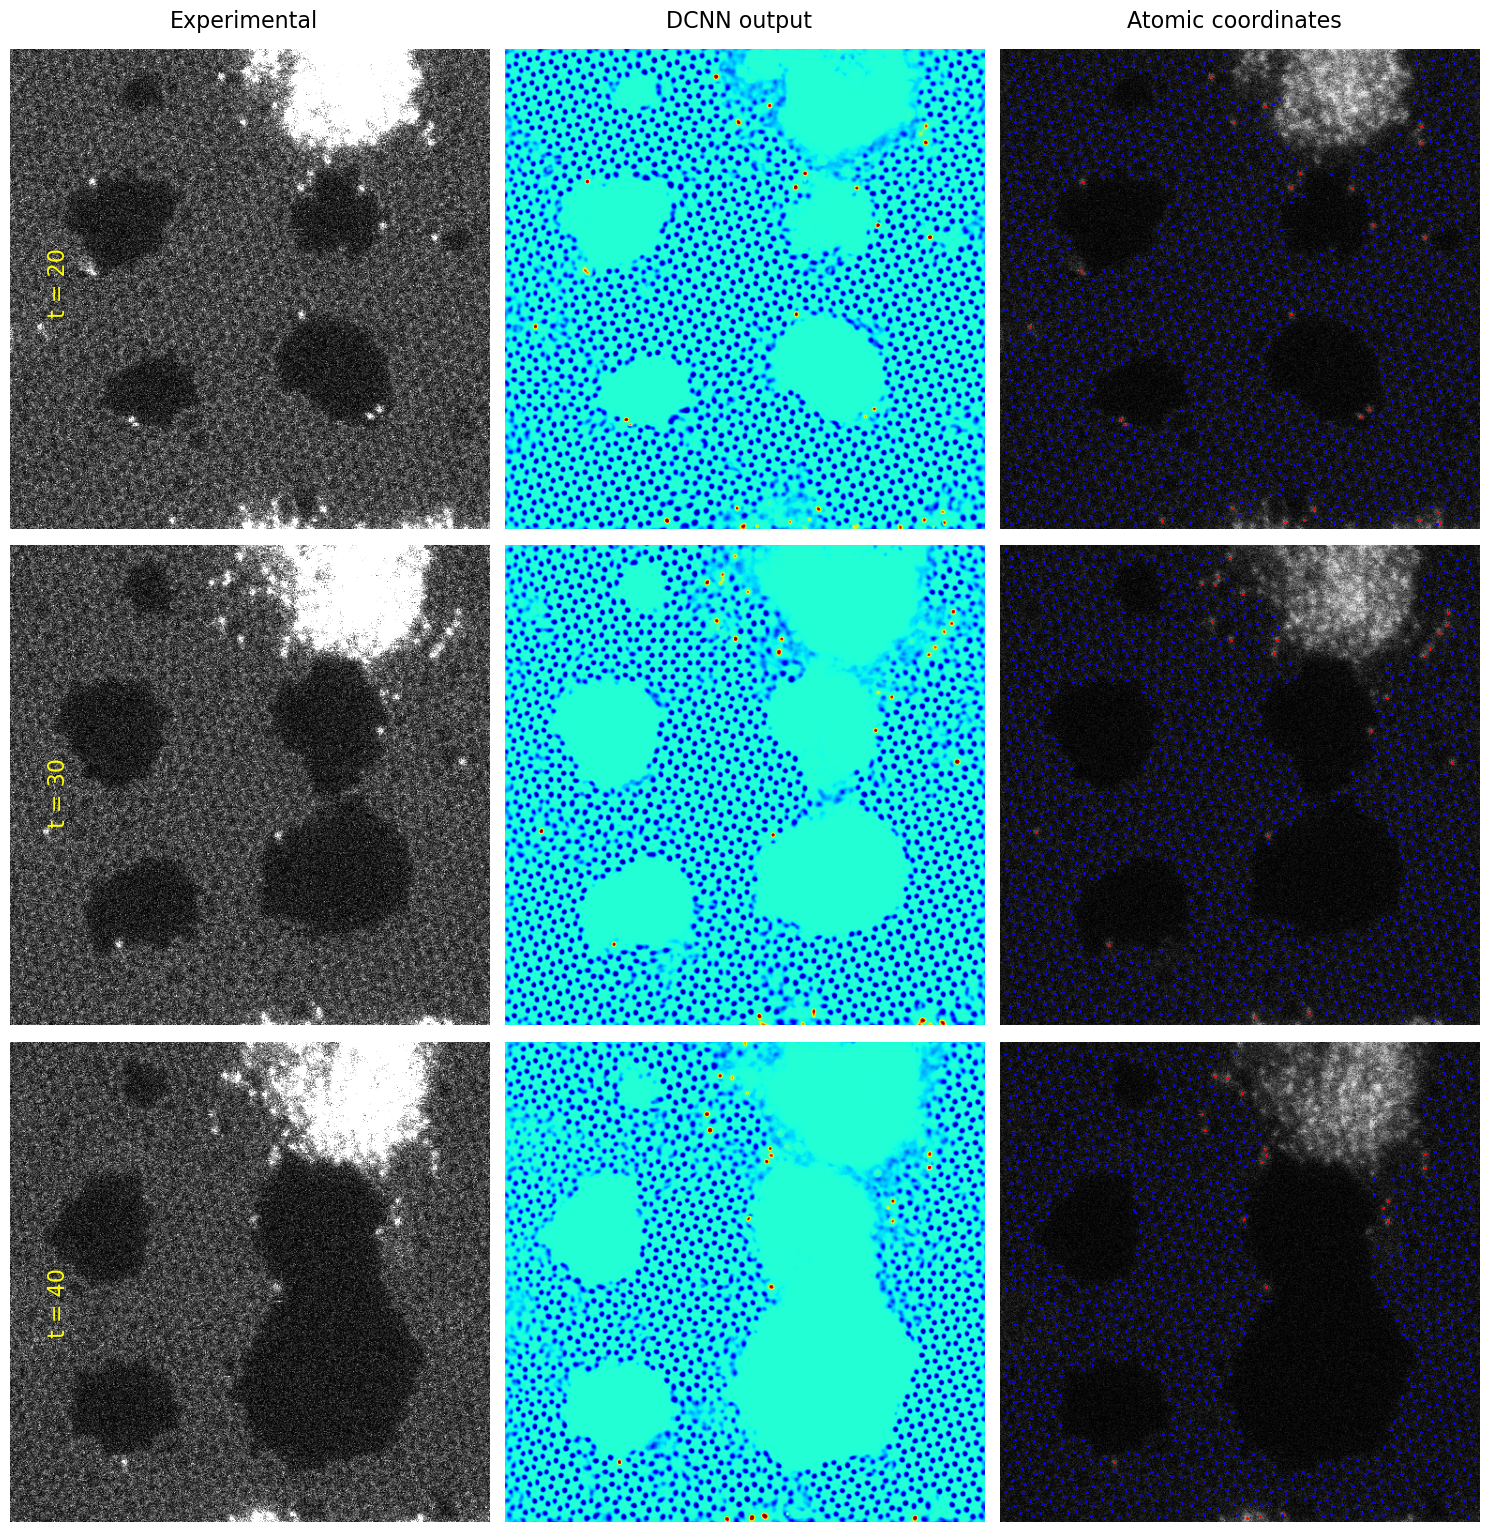

In [3]:
# Create a larger figure for 9 subplots
fig = plt.figure(figsize=(15, 17), dpi=100)

# Add column titles
col_titles = ["Experimental", "DCNN output", "Atomic coordinates"]
for idx, title in enumerate(col_titles):
    fig.text(0.166 + idx * 0.33, 0.9, title, ha="center", fontsize=16)

# Loop through different time frames
for idx, i in enumerate([20, 30, 40]):
    # Process image and get coordinates
    d_img = np.uint8(decoded_imgs[i] * 255)
    d_img = cv2.cvtColor(d_img, cv2.COLOR_BGR2GRAY)
    coord_Si = lattice_coord[i][np.where(lattice_coord[i][:, 2] == 1)][:, 0:2]
    coord_C = lattice_coord[i][np.where(lattice_coord[i][:, 2] == 0)][:, 0:2]

    # Add row title (time step)
    fig.text(
        0.05,
        0.75 - idx * 0.3,
        f"t = {i}",
        rotation=90,
        ha="right",
        va="center",
        color="yellow",
        fontsize=16,
    )

    # Create three subplots for each time frame
    ax1 = fig.add_subplot(3, 3, idx * 3 + 1)
    ax1.imshow(STEM_real[i, :, :, 0], vmin=0, vmax=0.3, cmap="gray")
    ax1.axis("off")

    ax2 = fig.add_subplot(3, 3, idx * 3 + 2)
    ax2.imshow(d_img, cmap="jet", interpolation="gaussian")
    ax2.axis("off")

    ax3 = fig.add_subplot(3, 3, idx * 3 + 3)
    ax3.scatter(coord_Si[:, 1], coord_Si[:, 0], c="red", s=1)
    ax3.scatter(coord_C[:, 1], coord_C[:, 0], c="blue", s=1)
    ax3.imshow(STEM_real[i, :, :, 0], cmap="gray")
    ax3.axis("off")

plt.tight_layout()  # Adjust spacing between subplots
# Add some padding at the top for column titles
plt.subplots_adjust(top=0.9)
plt.show()

In [4]:
d_imgs = np.sum(decoded_imgs[..., :-1], -1)

In [5]:
import torch

d = 24
batchsize = 20
frm_crop_stack = np.zeros((50, batchsize, d * d))

for i in range(batchsize):
    x = np.random.randint(0, d_imgs.shape[1] - d)
    y = np.random.randint(0, d_imgs.shape[2] - d)

    sub_images = d_imgs[:, x : x + d, y : y + d].reshape(50, d * d)
    frm_crop_stack[:, i] = sub_images

# frm_crop_stack = d_imgs[:, d : 2 * d, d : 2 * d]
frm_crop_stack = torch.Tensor(frm_crop_stack)
time_ts = (
    torch.arange(0, frm_crop_stack.shape[0], dtype=torch.float16)
    .unsqueeze(-1)
    .unsqueeze(-1)
    .repeat(1, batchsize, 1)
)  # Shape becomes [50, 9, 1, 1]
print(frm_crop_stack.shape)  ## torch.Size([50, 1, 784])
print(time_ts.shape)
print(time_ts.dtype)

torch.Size([50, 20, 576])
torch.Size([50, 20, 1])
torch.float16


In [6]:
def gen_batch(batch_size: int = 1, n_samples: int = 45):
    n_batch = (
        1
        if frm_crop_stack.shape[1] // batch_size == 0
        else frm_crop_stack.shape[1] // batch_size
    )
    time_len = frm_crop_stack.shape[0]
    n_samples = min(n_samples, time_len)
    for i in range(n_batch):
        if n_samples > 0:
            t0_idx = np.random.multinomial(
                1, [1.0 / (time_len - n_samples)] * (time_len - n_samples)
            )
            t0_idx = np.argmax(t0_idx)
            tM_idx = t0_idx + n_samples
        else:
            t0_idx = 0
            tM_idx = time_len

        yield frm_crop_stack[t0_idx:tM_idx], time_ts[t0_idx:tM_idx]

In [7]:
from NeuralODE.ODEVAE import ODEVAE


def set_torch_backend(platform: str):
    """
    Set the PyTorch backend based on the specified platform.

    Args:
        platform (str): The platform to use ('cuda', 'mps', 'cpu').

    Returns:
        torch.device: The selected torch device.

    Raises:
        ValueError: If the platform is not supported or available.
    """
    platform = platform.lower()

    if platform == "cuda":
        if torch.cuda.is_available():
            device = torch.device("cuda")
            torch.set_default_tensor_type(torch.cuda.FloatTensor)
            print("Using CUDA backend.")
        else:
            raise ValueError("CUDA is not available on this machine.")

    elif platform == "mps":
        if torch.backends.mps.is_available():
            device = torch.device("mps")
            print("Using MPS (Metal Performance Shaders) backend.")
        else:
            raise ValueError("MPS is not available on this machine.")

    elif platform == "cpu":
        device = torch.device("cpu")
        torch.set_default_tensor_type(torch.FloatTensor)
        print("Using CPU backend.")

    else:
        raise ValueError(
            f"Unsupported platform: {platform}. Supported platforms: 'cuda', 'mps', 'cpu'."
        )

    return device


DEVICE = set_torch_backend("mps")

Using MPS (Metal Performance Shaders) backend.


In [8]:
vae = ODEVAE(input_dim=d**2, hidden_dim=32, latent_dim=2, coord=3, device=DEVICE)
optim = torch.optim.Adam(vae.parameters(), betas=(0.9, 0.999), lr=0.01)
print(vae)

ODEVAE(
  (encoder): LSTMEncoder(
    (rnn): LSTM(577, 32)
    (layers): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): Tanh()
      (4): Linear(in_features=32, out_features=10, bias=True)
    )
  )
  (decoder): NeuralODEDecoder(
    (ode): NeuralODE(
      (odefunc): NNODEF(
        (lin1): Linear(in_features=5, out_features=32, bias=True)
        (lin3): Linear(in_features=32, out_features=5, bias=True)
        (elu): ELU(alpha=1.0, inplace=True)
      )
    )
    (decode_net): CoordBoost(
      (fc_coord): Sequential(
        (0): Linear(in_features=2, out_features=32, bias=True)
      )
      (fc_latent): Sequential(
        (0): Linear(in_features=2, out_features=32, bias=False)
      )
      (layers): Sequential(
        (0): Linear(in_features=32, out_features=32, bias=True)
        (1): Tanh()
        (2): Linear(in_features=32, out_features=32, bias=True)
     

In [9]:
import sys


# 线性退火
def linear_annealing(epoch, total_epochs, min_beta=0.0, max_beta=1.0):
    return min_beta + (max_beta - min_beta) * (epoch / total_epochs)


n_epochs = 1000

for epoch_idx in range(n_epochs):
    train_iter = gen_batch()
    for x, t in train_iter:
        # beta = torch.tensor(
        #     linear_annealing(epoch_idx, n_epochs, min_beta=0.0, max_beta=1.0)
        # )

        optim.zero_grad()
        x, t = x.to(DEVICE), t.to(DEVICE)

        max_len = np.random.choice([25, 35, 45])
        permutation = np.random.permutation(t.shape[0])
        np.random.shuffle(permutation)
        permutation = np.sort(permutation[:max_len])

        x, t = x[permutation], t[permutation]

        x_p, elbo, log_p_x_g_z, kl_div, _ = vae(x, t, beta=1.0)

        loss = -elbo
        loss.backward()
        optim.step()

        template = "\rTrain: [{}/{}] , ELBO={:.5f}, Recon_Loss={:.5f}, KL={:.5f}"
        print(
            template.format(
                epoch_idx + 1,
                n_epochs,
                elbo.item(),
                -log_p_x_g_z.item(),
                kl_div.item(),
            ),
            end="",
            file=sys.stderr,
        )

Train: [10/1000] , ELBO=-234.24414, Recon_Loss=234.03427, KL=0.20987

KeyboardInterrupt: 

In [ ]:
# with torch.no_grad():
# vae.eval()

x_p, elbo, log_p_x_g_z, kl_div, zs = vae(
    frm_crop_stack.to(DEVICE), time_ts.to(DEVICE), beta=0.0
)

In [ ]:
# 选择前 10 张图片
images = frm_crop_stack[:10, 0, :].detach().cpu().numpy().reshape(10, d, d)

# 创建 2 行 5 列的子图
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Frame {i+1}')

plt.tight_layout()
plt.show()

# 选择前 10 张图片
images = x_p[:10, 0, :].detach().cpu().numpy().reshape(10, d, d)

# 创建 2 行 5 列的子图
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Recon Frame {i+1}')

plt.tight_layout()
plt.show()

In [ ]:
time_steps = np.arange(50)  # 时间步 [0, 1, ..., 49]

# 提取隐变量数据并转换为 NumPy 数组
variables = zs[:, 0, :].detach().cpu().numpy()

# 绘制 5 个隐变量的时间序列
plt.figure(figsize=(10, 5))
labels = [
    "Rotation Angle",
    "Horizontal Position",
    "Vertical Position",
    "Hidden Var 4",
    "Hidden Var 5",
]
for i in range(5):
    plt.plot(time_steps, variables[:, i], label=labels[i])

plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.title("Hidden Variables Over Time")
plt.legend()
plt.grid()
plt.show()

### MNIST Part

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# 选择 1-9 各一张图片
target_digits = list(range(1, 10))

# 加载 MNIST 数据集
data = datasets.MNIST(
    root="./", train=True, download=True, transform=transforms.ToTensor()
)

# 筛选出每个目标数字的一张图片
digit_images = {}
for img, label in data:
    if label in target_digits and label not in digit_images:
        digit_images[label] = img.squeeze(0).numpy()
    if len(digit_images) == len(target_digits):
        break

# 旋转并整理为 Tensor
num_steps = 50
image_size = 28
rotated_tensor = torch.zeros((num_steps, len(target_digits), image_size, image_size))


def rotate_image(image, angle):
    return scipy.ndimage.rotate(image, angle, reshape=False, mode="nearest")


for step in range(num_steps):
    angle = step * (360 / num_steps)  # 每步旋转 (360/50) 度
    for i, d in enumerate(digit_images.keys()):
        rotated_tensor[step, i] = torch.tensor(rotate_image(digit_images[d], angle))

# 显示动画
fig, axes = plt.subplots(1, len(target_digits), figsize=(len(target_digits) * 2, 2))
if len(target_digits) == 1:
    axes = [axes]
img_displays = [
    ax.imshow(rotated_tensor[0, i].detach().cpu().numpy(), cmap="gray")
    for i, ax in enumerate(axes)
]
for ax, d in zip(axes, digit_images.keys()):
    ax.set_title(f"Digit {d}")
    ax.axis("off")


def update(frame):
    for i in range(len(target_digits)):
        img_displays[i].set_array(rotated_tensor[frame, i].detach().cpu().numpy())
    return img_displays


ani = FuncAnimation(fig, update, frames=num_steps, interval=50, blit=True)
plt.show()

In [ ]:
dynamics_rotated = rotated_tensor.view(50, 9, -1)
time_ts = (
    torch.arange(0, dynamics_rotated.shape[0], dtype=torch.float16)
    .unsqueeze(-1)
    .unsqueeze(-1)
    .repeat(1, 9, 1)
)  # Shape becomes [50, 9, 1]


def gen_mnist_batch(batch_size: int = 3, n_samples: int = 45):
    n_batches = dynamics_rotated.shape[1] // batch_size
    time_len = dynamics_rotated.shape[0]
    n_sample = min(n_samples, time_len)
    for i in range(n_batches):
        if n_sample > 0:  ## 截取整个时序范围内的一段 t0‘-t1'
            t0_idx = np.random.multinomial(
                1, [1.0 / (time_len - n_sample)] * (time_len - n_sample)
            )
            t0_idx = np.argmax(t0_idx)
            tM_idx = t0_idx + n_sample
        else:
            t0_idx = 0
            tM_idx = time_len

        frm, to = batch_size * i, batch_size * (i + 1)
        yield dynamics_rotated[t0_idx:tM_idx, frm:to], time_ts[t0_idx:tM_idx, frm:to]

In [ ]:
mnist_vae = ODEVAE(input_dim=784, hidden_dim=48, latent_dim=2, coord=3, device=DEVICE)
optim = torch.optim.Adam(mnist_vae.parameters(), betas=(0.9, 0.999), lr=0.01)

In [ ]:
import sys


# 线性退火
def linear_annealing(epoch, total_epochs, min_beta=0.0, max_beta=1.0):
    return min_beta + (max_beta - min_beta) * (epoch / total_epochs)


n_epochs = 1000

for epoch_idx in range(n_epochs):
    train_iter = gen_mnist_batch()
    for x, t in train_iter:
        beta = torch.tensor(
            linear_annealing(epoch_idx, n_epochs, min_beta=0.0, max_beta=1.0)
        )

        optim.zero_grad()
        x, t = x.to(DEVICE), t.to(DEVICE)

        max_len = np.random.choice([25, 35, 45])
        permutation = np.random.permutation(t.shape[0])
        np.random.shuffle(permutation)
        permutation = np.sort(permutation[:max_len])

        x, t = x[permutation], t[permutation]

        x_p, elbo, log_p_x_g_z, kl_div, _ = mnist_vae(x, t, beta=1.0)

        loss = -elbo
        loss.backward()
        optim.step()

        template = "\rTrain: [{}/{}] , ELBO={:.5f}, Recon_Loss={:.5f}, KL={:.5f}"
        print(
            template.format(
                epoch_idx + 1,
                n_epochs,
                elbo.item(),
                -log_p_x_g_z.item(),
                kl_div.item(),
            ),
            end="",
            file=sys.stderr,
        )

In [ ]:
x_p, elbo, log_p_x_g_z, kl_div, zs = mnist_vae(
    dynamics_rotated.to(DEVICE), time_ts.to(DEVICE), beta=0.0
)

In [ ]:
# 选择前 10 张图片
images = dynamics_rotated[:10, 0, :].detach().cpu().numpy().reshape(10, 28, 28)

# 创建 2 行 5 列的子图
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap="gray")
    ax.axis("off")
    ax.set_title(f"Frame {i+1}")

plt.tight_layout()
plt.show()

# 选择前 10 张图片
images = x_p[:10, 0, :].detach().cpu().numpy().reshape(10, 28, 28)

# 创建 2 行 5 列的子图
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap="gray")
    ax.axis("off")
    ax.set_title(f"Recon Frame {i+1}")

plt.tight_layout()
plt.show()